#   
<span style="font-family:Arial; font-weight:Bold; font-size:2.5em; color:#00b3e5;"> ARIMA

##   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Libraries

In [1]:
import numpy   as np
import pandas  as pd

import seaborn as sns
import matplotlib.pyplot as plt

from   statsmodels.tsa.arima.model         import  ARIMA                # ARIMA
from   statsmodels.tsa.statespace.sarimax  import SARIMAX               # Seasonal ARIMA

from   statsmodels.tsa.holtwinters         import ExponentialSmoothing  # Exponential Smoothing
from   statsmodels.tsa.vector_ar.var_model import VAR                   # Vector Autoregression

import warnings
warnings.filterwarnings('ignore')

##   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Reading TimeSeries

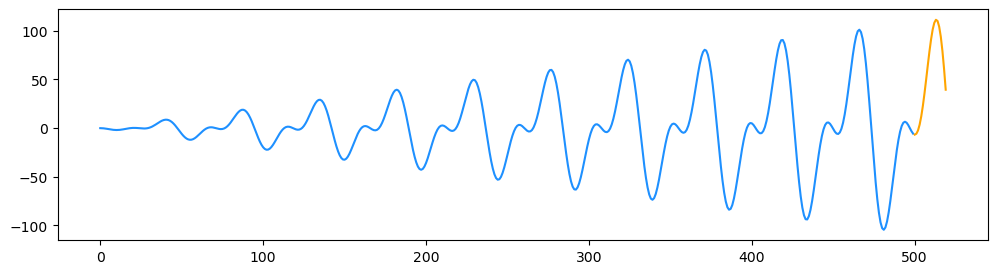

In [2]:
# Serie 
T_Series = range(500)
n_Series = len(T_Series)
Series   = [ 0.15*x*np.sin((25*x))+0.1*x*np.sin(50*x) for x in T_Series ] 

# Test
n_Test   = 20
T_Test   = range( n_Series, n_Series+n_Test )
Test     = [ 0.15*x*np.sin((25*x))+0.1*x*np.sin(50*x) for x in T_Test ]

# Visualization
plt.figure(figsize=(12,3)); 
plt.plot( T_Series, Series, color='dodgerblue' )
plt.plot( T_Test  , Test  , color='orange'     )
plt.show()

##   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Trend-Stationary Tests
 - **Augmented Dickey-Fuller Unit Root Test**
 - **Kwiatkowski-Phillips-Schmidt-Shin Test**

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Augmented Dickey-Fuller Unit Root Test
 - Tests whether a **time series** has a **unit root**, e.g. has a **trend** or more generally is **autoregressive**.

In [3]:
from statsmodels.tsa.stattools import adfuller

print("\n\nAugmented Dickey-Fuller Unit Root Test") 
stat, p, lags, obs, crit, t = adfuller( Series )

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)')
else: print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)')



Augmented Dickey-Fuller Unit Root Test
stat=-217967379.435, p=0.000
Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Kwiatkowski-Phillips-Schmidt-Shin Test
 - Tests whether a **time series** is **trend stationary or not**

In [4]:
from statsmodels.tsa.stattools import kpss
print("\nKwiatkowski-Phillips-Schmidt-Shin Test")  
stat, p, lags, crit = kpss( Series )
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)')
else: print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)')


Kwiatkowski-Phillips-Schmidt-Shin Test
stat=0.019, p=0.100
Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)


##   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Optimization
 - **ACF PACF**
 - **Auto_ARIMA**
 - **FOR Loop**

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> ACF PACF

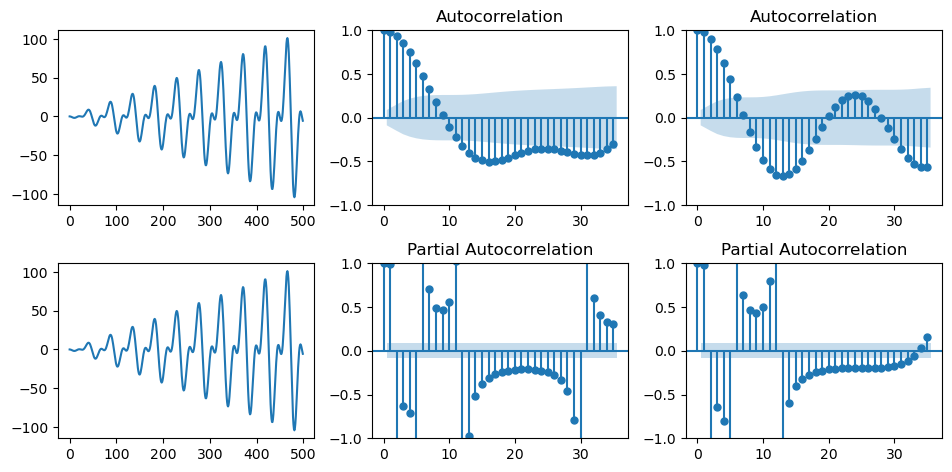

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ts = pd.DataFrame(Series)
fig, axes = plt.subplots(2,3)
axes[0,0].plot(ts)
plot_acf( ts, lags=35, ax=axes[0,1] )
plot_acf( ts.diff().dropna(), lags=35, ax=axes[0,2] )
axes[1,0].plot(ts)
plot_pacf( ts, lags=35, ax=axes[1,1] )
plot_pacf( ts.diff().dropna(), lags=35, ax=axes[1,2] )
plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=(0, 0, 1.5, 1))

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Auto_ARIMA

In [6]:
''' 
from pmdarima import auto_arima
auto_model = auto_arima( Serie, m=12, start_P=0, seasonal=True, error_action='ignore',
                         suppress_warnings=True, stepwise=True )
print(auto_model)
auto_model
''' 
pass

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> FOR Loop

In [7]:
PDQs, RMSEs,AICs,BICs = [], [], [], []

n_pq = 2
for p in range(n_pq):
    for d in range(2):
        for q in range(n_pq):
            
            try:
                sarimax = SARIMAX(
                    endog                   =  Series,
                    order                   = (p,d,q),
                    seasonal_order          = (0, 0, 0, 0),
                    trend_offset            =  1,
                    trend                   =  None,   # None,'n','c','t','ct'
                    exog                    =  None,
                    dates                   =  None,
                    freq                    =  None,
                    mle_regression          =  True,
                    enforce_stationarity    =  True,
                    enforce_invertibility   =  True,
                    validate_specification  =  True,
                    time_varying_regression =  False,
                    hamilton_representation =  False, 
                    simple_differencing     =  False,
                    concentrate_scale       =  False,
                    measurement_error       =  False,
                    use_exact_diffuse       =  False,   
                    missing                 = 'none'
                    )
                model = sarimax.fit()
                
                print( 'p, d, q =', [p,d,q] )
         
                PRED    = [ x for x in model.forecast(steps=n_Test) ] 
                SE      = [ (i-j)**2 for i,j in zip(PRED,Test) ]
                RMSE    =   (np.sum(SE)/n_Test)**0.5
                RMSEs.append(np.round(RMSE,1))
                
                PDQs.append( (p,d,q) )
                AICs.append(int(np.round(model.aic,-1)))
                BICs.append(int(np.round(model.bic,-1)))
        
            except:
                continue

p, d, q = [0, 0, 0]
p, d, q = [0, 0, 1]
p, d, q = [0, 1, 0]
p, d, q = [0, 1, 1]
p, d, q = [1, 0, 0]
p, d, q = [1, 0, 1]
p, d, q = [1, 1, 0]
p, d, q = [1, 1, 1]


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Results

In [8]:
df = pd.DataFrame( [RMSEs,PDQs,AICs,BICs] ).T
df.columns = ['rmse','( p, d, q )','aic','bic']
df.sort_values(['rmse'],ascending=[True],inplace=True)
df.head(3)

,rmse,"( p, d, q )",aic,bic
0,71.0,"(0, 0, 0)",5020,5020
1,71.0,"(0, 0, 1)",4340,4340
4,74.6,"(1, 0, 0)",3320,3330


##   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Models

In [9]:
# SARIMAX
sarimax = SARIMAX(
    endog                   =  Series,
    order                   = (5,0,0),
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,        # None,'n','c','t','ct'
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    mle_regression          =  True,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    time_varying_regression =  False,
    hamilton_representation =  False, 
    simple_differencing     =  False,
    concentrate_scale       =  False,
    measurement_error       =  False,
    use_exact_diffuse       =  False,   
    missing                 = 'none'
)
'''     
# ARIMA 
arima = ARIMA(
    endog                   =  Series,
    order                   = (1,1,1),
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    concentrate_scale       =  False,
    missing                 = 'none'
)    

# ExponentialSmoothing
ExpS = ExponentialSmoothing(
    endog                   =  Series,
    trend                   =  None,        # "add", "mul", "additive", "multiplicative", None
    seasonal                =  None,        # "add", "mul", "additive", "multiplicative", None
    seasonal_periods        =  None,
    initial_level           =  None,        # float
    initial_trend           =  None,        # float
    initial_seasonal        =  None,
    bounds                  =  None,
    dates                   =  None,
    freq                    =  None,
    damped_trend            =  False,
    use_boxcox              =  False,
    initialization_method   = 'estimated',  # 'estimated','heuristic','legacy-heuristic', 'known', None
    missing                 = 'none'        # 'none', 'drop', 'raise'
)
''' 
pass

## 
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Fitting

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(5, 0, 0)   Log Likelihood                2360.261
Date:                Fri, 01 Dec 2023   AIC                          -4708.523
Time:                        15:54:45   BIC                          -4683.235
Sample:                             0   HQIC                         -4698.600
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          4.8844      0.010    499.310      0.000       4.865       4.904
ar.L2         -9.6310      0.038   -251.101      0.000      -9.706      -9.556
ar.L3          9.5826      0.057    167.404      0.0

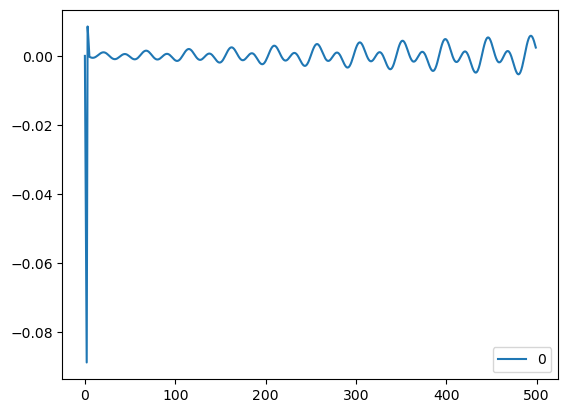

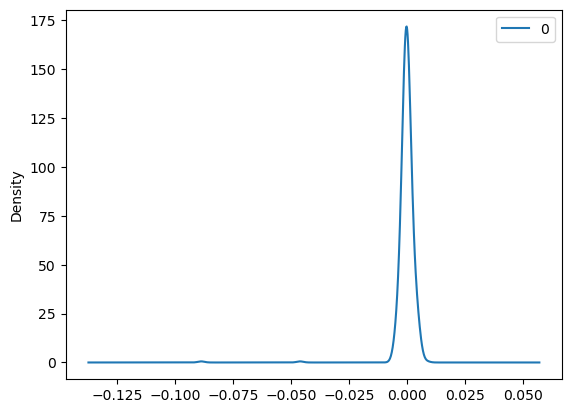

                0
count  500.000000
mean    -0.000208
std      0.004937
min     -0.088754
25%     -0.001138
50%     -0.000091
75%      0.001028
max      0.008518


In [10]:
# fitted model
model = sarimax.fit()

# summary of fit model
print(model.summary())

# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

## 
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Forecasting Test Data

In [11]:
# forcasting  
PRED    = [ x for x in model.forecast(steps=n_Test) ] 
SE      = [ (i-j)**2 for i,j in zip(PRED,Test) ]
RMSE    =   (np.sum(SE)/n_Test)**0.5
RMSE

3.202184767049207

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Visualizing The Forecast

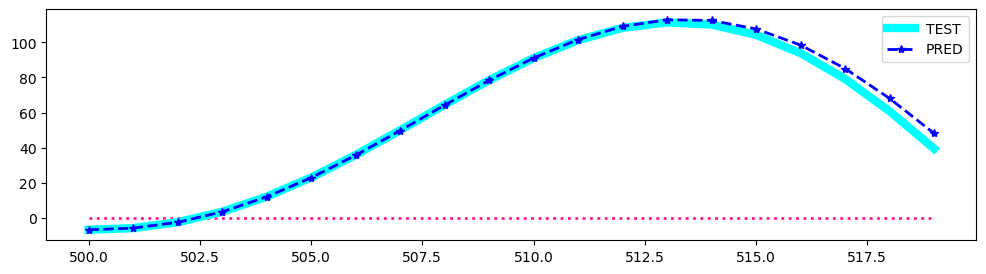

In [12]:
# visualizing
plt.figure( figsize=(12,3) )
plt.plot( [T_Test[0],T_Test[-1]], [0,0] ,  ":"  ,                color='deeppink' ,linewidth=2 )
plt.plot(        T_Test         , Test  ,  "-"  , label="TEST" , color='cyan'     ,linewidth=6 )
plt.plot(        T_Test         , PRED  , "--*" , label="PRED" , color='blue'     ,linewidth=2 )
plt.legend(); plt.show()

#####   

## 
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Final Model

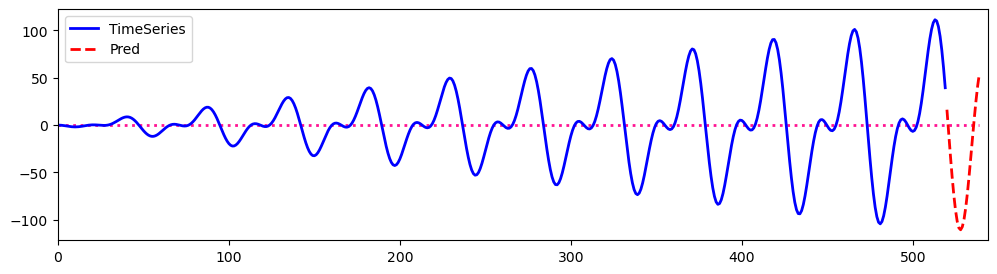

In [13]:
# input
p, q, d = 5, 0, 0
SD      = 0.004937
n_Steps = n_Test 

# auto
TimeSeries   = Series+Test
n_TimeSeries =  len(    TimeSeries )
T_TimeSeries = range( n_TimeSeries )

model = SARIMAX(
    endog                   =  TimeSeries,
    order                   = (p,q,d),
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,        # None,'n','c','t','ct'
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    mle_regression          =  True,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    time_varying_regression =  False,
    hamilton_representation =  False, 
    simple_differencing     =  False,
    concentrate_scale       =  False,
    measurement_error       =  False,
    use_exact_diffuse       =  False,   
    missing                 = 'none'
).fit() 

# Forecasting Unknown Future
Pred        = [ x for x in model.forecast(steps=n_Steps) ]
T_Pred      = range( n_TimeSeries, n_TimeSeries+n_Steps )

# Confidence Interval
Pred_95_Top = [ x+2*SD for x in Pred ]
Pred_68_Top = [ x+1*SD for x in Pred ] 
Pred_68_Bot = [ x-1*SD for x in Pred ] 
Pred_95_Bot = [ x-2*SD for x in Pred ]  

# Visualizing
plt.figure( figsize=(12,3) )
plt.plot( [T_TimeSeries[0],T_Pred[-1]],   [0,0]    ,  ":" , color='deeppink'  , linewidth=2                     ) 
plt.plot(          T_TimeSeries       , TimeSeries ,  "-" , color='blue'      , linewidth=2, label="TimeSeries" )
plt.plot(          T_Pred             , Pred       , "--" , color='red'       , linewidth=2, label="Pred"       )
#plt.plot(          T_Pred             , Pred_95_Top, "--" , color='dodgerblue', linewidth=2, label="95% CI"     )
#plt.plot(          T_Pred             , Pred_68_Top, "--" , color='lime'      , linewidth=2, label="68% CI"     )
#plt.plot(          T_Pred             , Pred_68_Bot, "--" , color='lime'      , linewidth=2                     )
#plt.plot(          T_Pred             , Pred_95_Bot, "--" , color='dodgerblue', linewidth=2                     ) 
plt.xlim( 0, T_Pred[-1]+5 )
plt.legend(); plt.show()

#####   

#####   